In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
from train_flow_sb import unflatten, object_from_config

In [4]:
api = wandb.Api()

In [5]:
run = api.run('druhe/gw-src/16pgb80c')

In [6]:
config = unflatten(run.config)

In [7]:
dataset = object_from_config(config, key='dataset')(**config['dataset'])

In [8]:
sb_weight = config['model']['sb_weight']

In [9]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [10]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [11]:
tempdir = tempfile.TemporaryDirectory()

In [12]:
ckpt = checkpoints[0]

In [13]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [14]:
model = HierarchicalNormalizingFlowSB.load_from_checkpoint(ckpt_path.name, dataset=dataset, sb_weight=sb_weight, flows=flows)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpl3iu7v9m
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpl3iu7v9m/_remote_module_non_sriptable.py


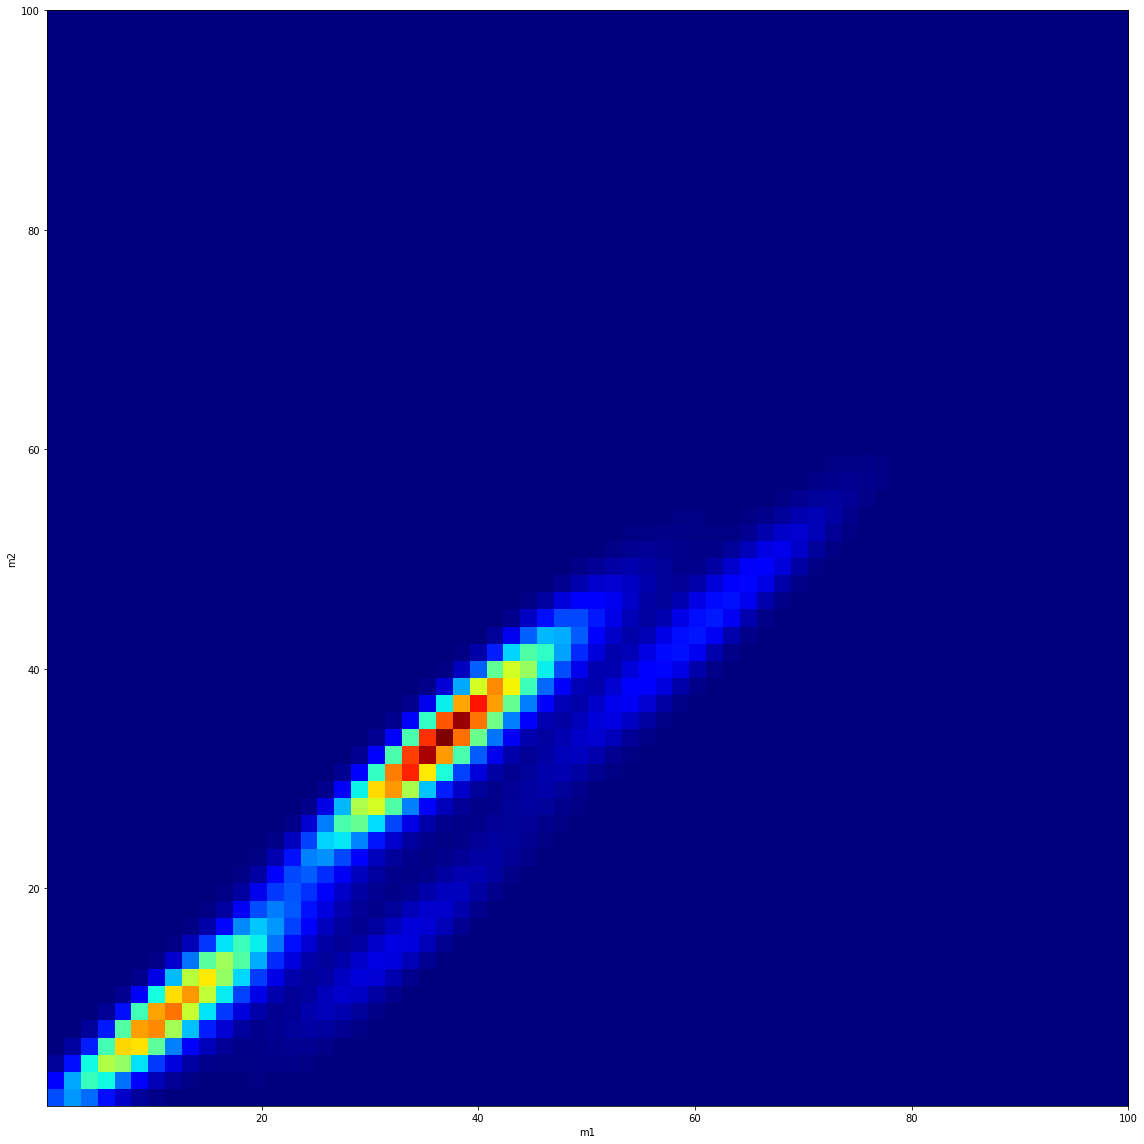

In [15]:
with torch.no_grad():
    axes_names = []
    axes = []

    for n, ax in dataset.grid.items():
        axes_names.append(n)
        axes.append(ax)

    m1, m2, z = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(3, -1)

    if dataset.has_normalization:
        raise NotImplementedError
        x, y = dataset.normalize_forward(x, y)

    resolutions = [len(ax) for ax in axes]

    input = np.stack([m1, m2, z], axis=-1)
    input = torch.from_numpy(input).float()
    prob = model.log_prob(input).exp().view(*resolutions)

    pm1m2 = prob.sum(-1)

    fig = plt.figure(figsize=(16, 16), facecolor="white")
    plt.imshow(
        pm1m2,
        cmap="jet",
        origin="lower",
        extent=(
            axes[0][0],
            axes[0][-1],
            axes[1][0],
            axes[1][-1],
        ),  # origin='lower' changes the order
        aspect="auto",
    )

    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()



In [16]:
dataset.gw_train_batch_size = 1024
dataset.sel_train_batch_size = 1024

In [17]:
gw_loader, sel_loader  = dataset.train_dataloader()

In [18]:
gw_batch = next(iter(gw_loader))

sel_batch = next(iter(sel_loader))

In [19]:
model.step((gw_batch, sel_batch), 0)

tensor(4.9680, dtype=torch.float64, grad_fn=<NegBackward0>)

In [20]:
import math

In [21]:

import torch
from torch.autograd.functional import hessian
from torch.nn.utils import _stateless

mod = torch.nn.Linear(2, 2)
inp = torch.rand(1, 2)

def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)



In [309]:
names = list(n for n, _ in mod.named_parameters())

def loss(*params):
    out: torch.Tensor = _stateless.functional_call(mod, {n: p for n, p in zip(names, params)}, inp)
    return out.square().sum()


H = hessian(loss, tuple(p for n, p in mod.named_parameters() if 'weight' in n))


In [491]:
names = list(n for n, _ in mod.named_parameters())

def loss(*params):
    params = list(params)
    for i in range(len(params)):
        if 'weight' in names[i]:
            d = int(math.sqrt(len(params[i])))
            params[i] = params[i].view(d, d)
    out: torch.Tensor = _stateless.functional_call(mod, {n: p for n, p in zip(names, params)}, inp)
    return out.square().sum()


H = hessian(loss, tuple(p.flatten() for n, p in mod.named_parameters()))


In [492]:
hessian = torch.cat([torch.cat(H[r], dim=1) for r in range(len(H))])

In [746]:
from torch.autograd.functional import hessian, jacobian

# inp = (gw_batch, sel_batch), 0


def loss(*params):
    params = list(params)
    for i in range(len(params)):
        if 'weight' in names[i]:
            d = int(math.sqrt(len(params[i])))
            params[i] = params[i].view(d, d)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)
    return -out.mean()


names = list(n for n, _ in model.named_parameters())
H = hessian(loss, tuple(p.flatten() for n, p in model.named_parameters()))
J = jacobian(loss, tuple(p.flatten() for n, p in model.named_parameters()))


In [747]:
N = len(input)

In [748]:
H = torch.cat([torch.cat(H[r], dim=1) for r in range(len(H))]).double()

In [749]:
I = -H / N

In [750]:
L, V = torch.linalg.eig(H)


In [751]:
L.real = L.real.clamp(min=1e-8, max=0.00001)

In [752]:
Q = V @ torch.diag(L) @ torch.linalg.inv(V)

In [753]:
Q = Q.real

In [754]:
Q = (Q + Q.T) / 2

In [755]:
L = torch.cholesky(Q)

In [756]:
L.max()

tensor(0.0031, dtype=torch.float64)

In [757]:
p, i = flatten_params(model.parameters())

In [758]:
mvn = torch.distributions.MultivariateNormal(p.squeeze(), scale_tril=L.float())

In [764]:
p_ = mvn.sample()

In [765]:
# p_ = p + torch.randn_like(p) * 1e-9

In [766]:
params_ = unflatten_params(p_, i, model)

In [767]:
def loss(*params):
    params = list(params)
    for i in range(len(params)):
        if 'weight' in names[i]:
            d = int(math.sqrt(len(params[i])))
            params[i] = params[i].view(d, d)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)
    return out


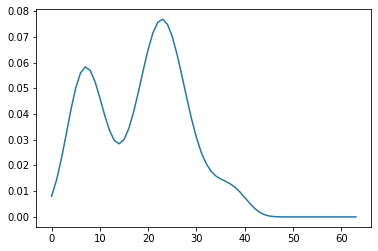

In [768]:
with torch.no_grad():
    prob = loss(*params_).exp().view(*resolutions)

    pm1m2 = prob.sum(-1)

    fig = plt.figure(figsize=(16, 16), facecolor="white")
    plt.imshow(
        pm1m2,
        cmap="jet",
        origin="lower",
        extent=(
            axes[0][0],
            axes[0][-1],
            axes[1][0],
            axes[1][-1],
        ),  # origin='lower' changes the order
        aspect="auto",
    )

    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()
    plt.close()
    plt.plot(pm1m2.sum(0))
    plt.show()

